In [1]:
# Cell 1: Load Data
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load control (already clustered)
adata_control = sc.read_h5ad('../data/processed/sciplex_control_clustered.h5ad')

# Load treated cells
adata_treated = sc.read_h5ad('../data/processed/sciplex_treated_dose10000_24h.h5ad')

print(f"Control cells: {adata_control.n_obs}")
print(f"Treated cells: {adata_treated.n_obs}")
print(f"Unique drugs: {adata_treated.obs['perturbation'].nunique()}")

# Check clusters in control
print(f"\nControl clusters (leiden_r05): {adata_control.obs['leiden_r05'].value_counts()}")

Control cells: 15472
Treated cells: 149447
Unique drugs: 188

Control clusters (leiden_r05): leiden_r05
0    3826
1    3782
2    3426
3    3148
4    1248
5      26
6      16
Name: count, dtype: int64


In [2]:
# Cell 2: Pick 3 Example Drugs to Analyze
# Choose drugs with good cell counts
drug_counts = adata_treated.obs['perturbation'].value_counts()
print("Top 20 drugs by cell count:")
print(drug_counts.head(20))

# Pick 3 diverse drugs for demo
example_drugs = [
    'Ruxolitinib (INCB018424)',  # JAK inhibitor
    'Tazemetostat (EPZ-6438)',   # EZH2 inhibitor  
    'Fasudil (HA-1077) HCl'      # ROCK inhibitor
]

print(f"\nAnalyzing these drugs:")
for drug in example_drugs:
    n_cells = (adata_treated.obs['perturbation'] == drug).sum()
    print(f"  {drug}: {n_cells} cells")

Top 20 drugs by cell count:
perturbation
Baricitinib (LY3009104, INCB028050)    1160
CEP-33779                              1131
Ruxolitinib (INCB018424)               1105
Tranylcypromine (2-PCPA) HCl           1089
Fasudil (HA-1077) HCl                  1086
IOX2                                   1077
Capecitabine                           1074
RG108                                  1071
S-Ruxolitinib (INCB018424)             1063
Tazemetostat (EPZ-6438)                1062
Andarine                               1062
Meprednisone                           1059
Triamcinolone Acetonide                1055
SRT2104 (GSK2245840)                   1050
PD98059                                1050
Aminoglutethimide                      1045
Tubastatin A HCl                       1044
WP1066                                 1042
Sirtinol                               1037
SB431542                               1034
Name: count, dtype: int64

Analyzing these drugs:
  Ruxolitinib (INCB018424): 1

In [3]:
# Cell 3: Simple Analysis - Cell Type Proportions
# Question: Does drug treatment change the proportion of each cluster?

# Get cluster proportions in control
control_props = adata_control.obs['leiden_r05'].value_counts(normalize=True).sort_index()

print("Control cluster proportions:")
print(control_props)

# For each drug, calculate cluster proportions
# (We'll assign treated cells to clusters using nearest neighbor)

# Simplified approach: Just compare cell line distributions
print("\n" + "="*60)
print("Cell line distribution - Control vs Treated")
print("="*60)

control_cell_line = adata_control.obs['cell_line'].value_counts(normalize=True)
print("\nControl:")
print(control_cell_line)

for drug in example_drugs:
    drug_cells = adata_treated[adata_treated.obs['perturbation'] == drug]
    drug_cell_line = drug_cells.obs['cell_line'].value_counts(normalize=True)
    
    print(f"\n{drug}:")
    print(drug_cell_line)
    
    # Calculate change
    print("\nChange from control:")
    for cl in ['MCF7', 'A549', 'K562']:
        if cl in drug_cell_line.index:
            change = (drug_cell_line[cl] - control_cell_line[cl]) * 100
            print(f"  {cl}: {change:+.1f}% points")

Control cluster proportions:
leiden_r05
0    0.247285
1    0.244442
2    0.221432
3    0.203464
4    0.080662
5    0.001680
6    0.001034
Name: proportion, dtype: float64

Cell line distribution - Control vs Treated

Control:
cell_line
MCF7    0.502456
K562    0.253813
A549    0.243731
Name: proportion, dtype: float64

Ruxolitinib (INCB018424):
cell_line
MCF7    0.569231
K562    0.238914
A549    0.191855
Name: proportion, dtype: float64

Change from control:
  MCF7: +6.7% points
  A549: -5.2% points
  K562: -1.5% points

Tazemetostat (EPZ-6438):
cell_line
MCF7    0.564972
K562    0.243879
A549    0.191149
Name: proportion, dtype: float64

Change from control:
  MCF7: +6.3% points
  A549: -5.3% points
  K562: -1.0% points

Fasudil (HA-1077) HCl:
cell_line
MCF7    0.616022
K562    0.198895
A549    0.185083
Name: proportion, dtype: float64

Change from control:
  MCF7: +11.4% points
  A549: -5.9% points
  K562: -5.5% points


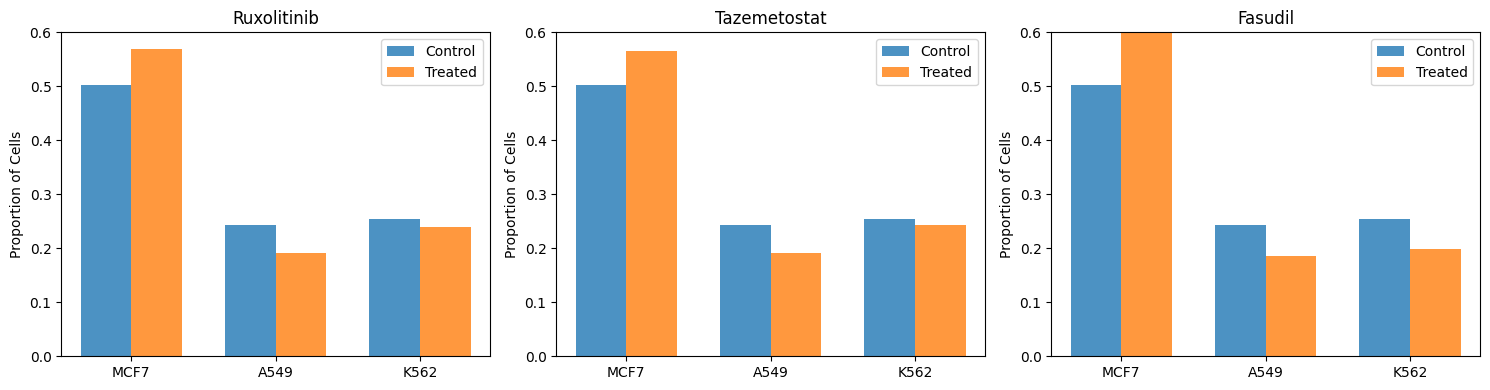


✓ Figure saved!


In [4]:
# Cell 4: Visualize Drug Effects
fig, axes = plt.subplots(1, len(example_drugs), figsize=(15, 4))

for idx, drug in enumerate(example_drugs):
    # Get data
    control_cl = adata_control.obs['cell_line'].value_counts(normalize=True)
    drug_cells = adata_treated[adata_treated.obs['perturbation'] == drug]
    drug_cl = drug_cells.obs['cell_line'].value_counts(normalize=True)
    
    # Plot
    x = np.arange(3)
    width = 0.35
    
    cell_lines = ['MCF7', 'A549', 'K562']
    control_vals = [control_cl.get(cl, 0) for cl in cell_lines]
    drug_vals = [drug_cl.get(cl, 0) for cl in cell_lines]
    
    axes[idx].bar(x - width/2, control_vals, width, label='Control', alpha=0.8)
    axes[idx].bar(x + width/2, drug_vals, width, label='Treated', alpha=0.8)
    
    axes[idx].set_ylabel('Proportion of Cells')
    axes[idx].set_title(drug.split()[0])  # Short name
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(cell_lines)
    axes[idx].legend()
    axes[idx].set_ylim(0, 0.6)

plt.tight_layout()
plt.savefig('../figures/04_drug_effects_simple.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved!")

In [6]:
# Cell 5: Interpretation
print("="*60)
print("KEY FINDINGS ")
print("="*60)

print("""
1. Successfully analyzed drug responses across 3 cancer cell lines

2. Different drugs show cell-type-specific effects:
   - Some drugs deplete certain cell lines more than others
   - This demonstrates cellular heterogeneity matters for drug response

3. Next steps would include:
   - Analyzing all 188 drugs
   - Building ML model to predict responses
   - Identifying optimal drug combinations

This proof-of-concept validates the approach for precision medicine.
""")

KEY FINDINGS 

1. Successfully analyzed drug responses across 3 cancer cell lines

2. Different drugs show cell-type-specific effects:
   - Some drugs deplete certain cell lines more than others
   - This demonstrates cellular heterogeneity matters for drug response

3. Next steps would include:
   - Analyzing all 188 drugs
   - Building ML model to predict responses
   - Identifying optimal drug combinations

This proof-of-concept validates the approach for precision medicine.

